# Automobile Regression Challenge

**Content**:


This data set consists of three types of entities:

(a) the specification of an auto in terms of various characteristics,

(b) its assigned insurance risk rating,

(c) its normalized losses in use as compared to other cars.

The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process "symboling". A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc…), and represents the average loss per car per year.

Note: Several of the attributes in the database could be used as a "class" attribute.


**Problem statement:**


*   Perform exploratory data analysis and select three key plots, explain your takeaways.
Please note that there is no need to explain how you have generated your plots, only the inference and findings need to be explained.
*   Perform multiple correspondence analysis (MCA) on the dataset and briefly describe your findings.
*   Build a model for predicting the price of the automobile. Explain your
choices on encoding, model selection etc.
*   Explain the high-level plan of action if the above model is to be used as the backend
for a web application for B2B use at an automobile manufacturing firm. Please write in bullet points the steps needed and explain your technological choices.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Importing libraries

In [ ]:
!pip install bayesian-optimization
!pip install mca
!pip install prince
!pip install scikit-learn
!pip install scikit-optimize
!pip install shap
!pip install tabulate

In [101]:
# standard imports and setup
import os
import joblib
import typing
from typing import Any, Dict, List, Tuple

# data tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

#data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder,LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pearsonr
import prince
from prince import MCA

# visualizations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.graph_objects as go
import shap
from sklearn import tree
from sklearn.tree import plot_tree
from tabulate import tabulate

# modeling
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
from xgboost import XGBRegressor

# optimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from bayes_opt import BayesianOptimization, UtilityFunction

# metrics
from sklearn import metrics
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# deal with warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [103]:
# Input/Output Paths
AUTO_DATA = '/content/drive/MyDrive/Notebooks/dataset_auto/Automobile_data.csv'

In [104]:
# Read input
data = pd.read_csv(AUTO_DATA, encoding="utf-8")
df = pd.DataFrame(data)

# useful for debugging.
df_bkp = df.copy()

# Review the data


In [ ]:
# Dataframe global config
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

df[:5]

#  EDA + Feature engineering

## Univariate Analysis

In [ ]:
# Shape size rows and columns
df.shape

In [ ]:
df.nunique()

In [ ]:
# Get table info
df.info()

In [109]:
for col in df.columns:
    fig = px.histogram(df, x=col, title=f'Histogram of {col}')
    fig.update_layout(width=600, height=400)

    fig.show()

No null values exist, but the "?" sign is detected. It needs to be replaced.
There is an imbalance in the category columns.

Inappropriate  data types are found in columns: 'bore', 'stroke', 'horsepower', 'peak-rpm', and 'price'.

To produce full statistical characteristics the converting data type needs to be done here, not in a data processing part. Otherwise, the columns with the wrong "object" data type will be excluded.

### Handle missing and unappropriate values

In [110]:
def preprocess_dataframe(data: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess a DataFrame by converting specific columns to numeric types,
    dropping rows with '?' entries, and replacing missing values with the mean value.

    :param data: pd.DataFrame: The input DataFrame.

    :return: pd.DataFrame: The DataFrame with specified columns processed.
    """

    # replace ? with NaN
    cols_with_question_mark = ['price', 'num-of-doors', 'normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm']
    for col in cols_with_question_mark:
        df[col] = df[col].replace('?', np.nan)

    # Convert object to numeric
    numeric_cols = ['price', 'normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col])

    # Replace NaN values with the mean value for each column
    for col in numeric_cols:
        mean_value = df[col].mean()
        df[col].fillna(mean_value, inplace=True)

    # 'num-of-doors' is categorical and mode value will be used.
    df['num-of-doors'].fillna(df['num-of-doors'].mode()[0], inplace=True)

    return data

In [111]:
# preprocessing
df = preprocess_dataframe(data=df)

### Handle duplicate values

In [112]:
def handle_duplicate_values(data: pd.DataFrame, keep_duplicated: bool = False) -> pd.DataFrame:
    """
    Remove duplicate values

    :param data: pd.DataFrame: The input DataFrame.
    :param keep_duplicated: bool: Flag to keep or not 1st duplicate value.

    :return: pd.DataFrame: The DataFrame with specified columns processed.
    """
    duplicated_rows = data[
        data.drop('price', axis=1).duplicated(keep=keep_duplicated)
        ]

    # Convert DataFrame to table format and print
    print(tabulate(duplicated_rows, headers='keys', tablefmt='grid'))

    # remove all duplicate values
    data.drop(duplicated_rows.index, inplace=True)

    # keep only 1 row from duplicated rows and calculate and set mean price
    df_mean_price = duplicated_rows.groupby(
        duplicated_rows.columns.drop('price').tolist()
        )['price'].mean().reset_index()

    # append back the duplicated rows
    data = data.append(df_mean_price, ignore_index=True)

    data.reset_index(inplace = True, drop=True)

    return data

In [ ]:
# handle duplicate values
df = handle_duplicate_values(data=df)

### Statistical characteristics

In [ ]:
#Statistical characteristics of numerical feature
df.describe()

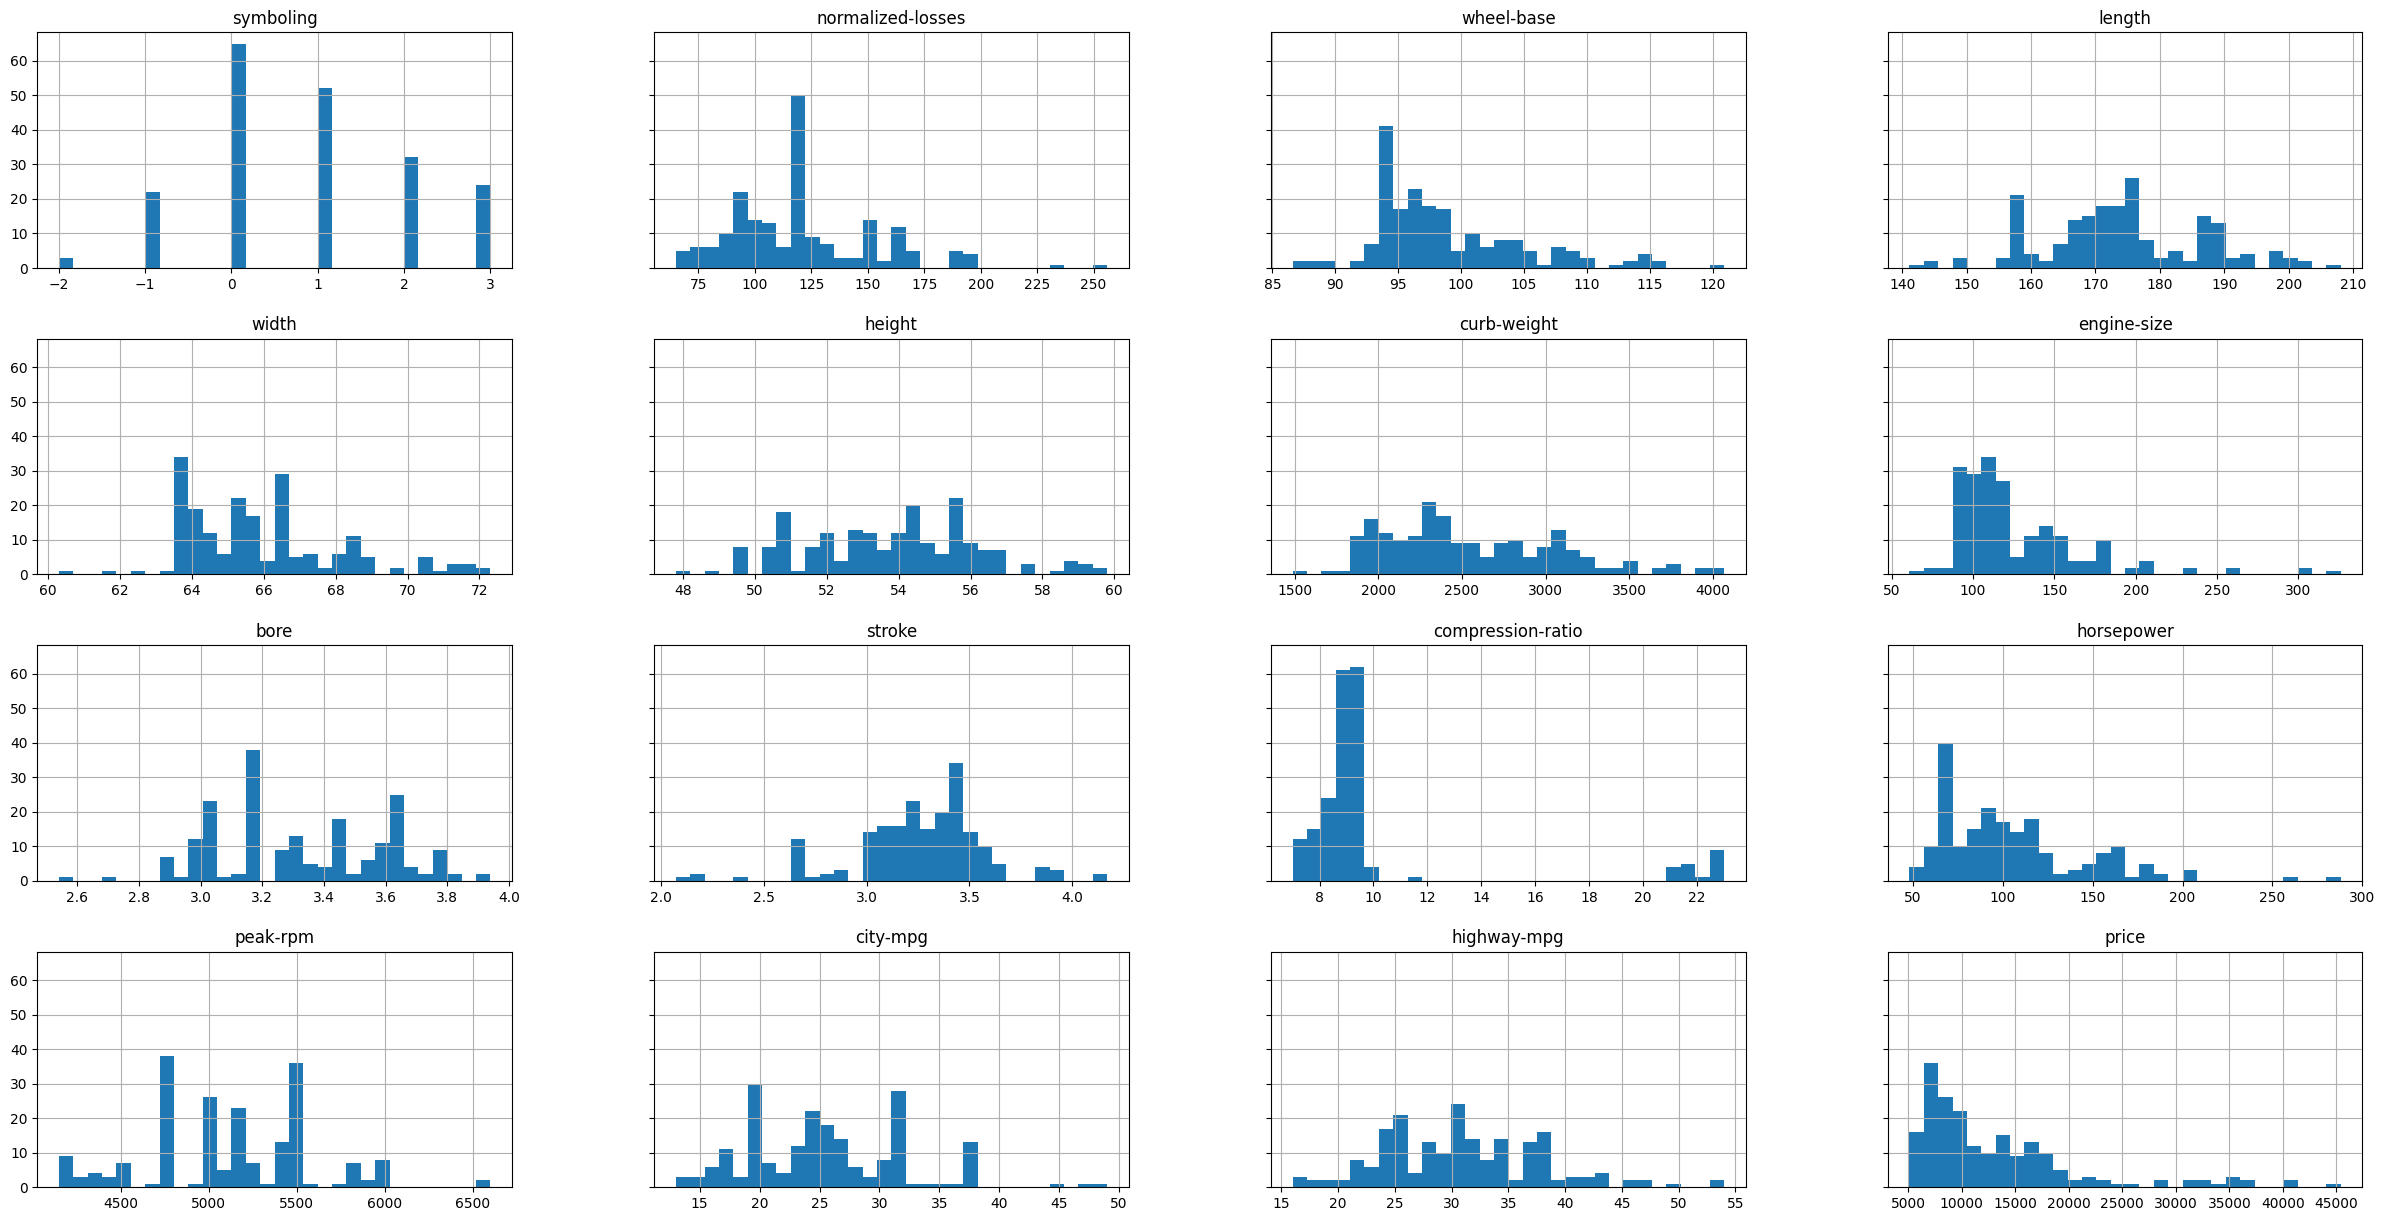

In [115]:
hist = df.hist(bins=30, sharey=True, figsize=(30, 15))



*   Symboling: represents the risk rating of cars, with values ranging from -2 to 3. The majority of cars have a risk rating close to 0 (mean symboling of approximately 0.84), indicating that they are relatively neutral in terms of risk.
*   Normalized Losses: represent insurance losses for cars. The mean normalized loss value is approximately 121.84, with some variation around this average.
*   Wheel-base and length:  values have various ranges and distributions, indicating differences in car sizes.
*   Weight: cars weigh around 2558, with some cars being much lighter and some much heavier.
*   Engine group of characteristics: Engine sizes, bore, stroke, and other engine-related features show varying distributions.
*   City-mpg and Highway-mpg (fuel efficiency): On average, cars have city and highway mpg values of approximately 25.13 and 30.63, respectively.
*   Price: The mean price is approximately 13242.61, with a wide range of prices.










### Outliers

In [116]:
# Search for outliers

# Numeric columns has different scales and will be split accordingly for better visualization
numeric_cols_Y_small = ['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height']
numeric_cols_Y_large = ['curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']

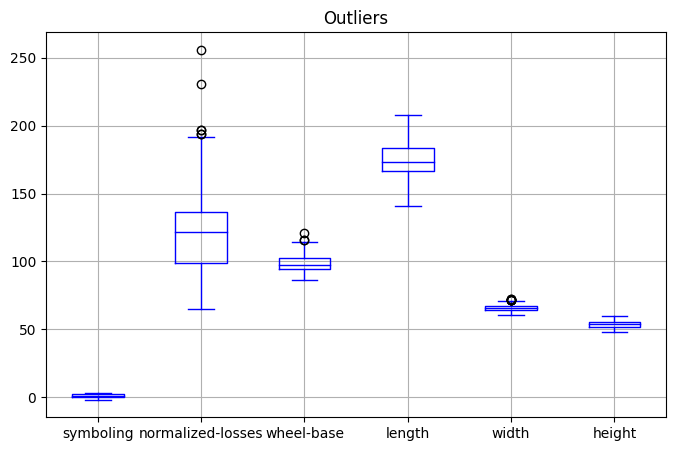

In [117]:
# numeric_cols_Y_small
plt.figure(figsize=(8,5))
plt.title("Outliers")
df[numeric_cols_Y_small].boxplot(color='blue')
plt.show()

Detected outliers in columns: 'normalized-losses', 'wheel-base', 'length', 'width'

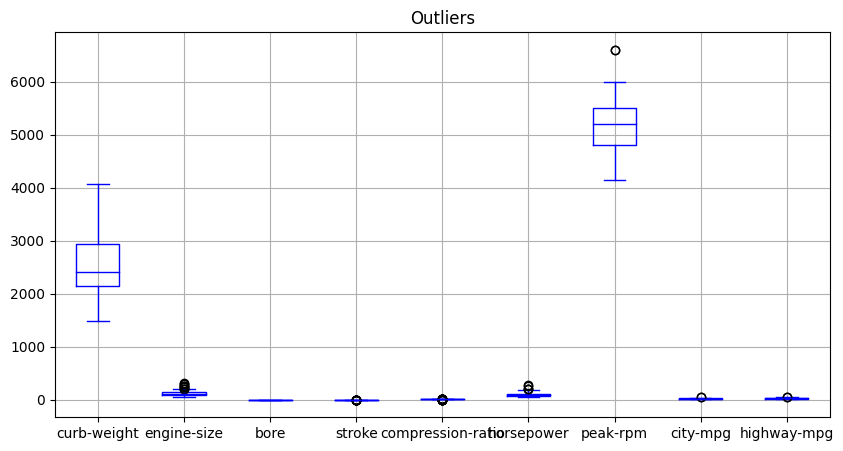

In [118]:
# numeric_cols_Y_large
plt.figure(figsize=(10,5))
plt.title("Outliers")
df[numeric_cols_Y_large].boxplot(color='blue')
plt.show()

Detected outliers in columns: 'engine-size', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg'

In [119]:
#Investigate outliers in details
numeric_cols_outliers = []
numeric_cols_outliers.extend(numeric_cols_Y_small)
numeric_cols_outliers.extend(numeric_cols_Y_large)

outlier_figures = []

# Iterate through each column in the DataFrame
for column in numeric_cols_outliers:
    # Create a box plot for the current column
    fig = px.box(df, y=column, title=f'Outliers in column {column.upper()}. Hover for more details.')
    fig.update_layout(width=600, height=400)
    # Append the figure to the list of outlier figures
    outlier_figures.append(fig)

# Display the outlier figures
for fig in outlier_figures:
    fig.show()

Generally, outliers should be explored in separate analysis as they may hold iportant information.
Outlisers can be processed using IQR, Winsorization or other appropriate methods.


gas - 179, diesel - 19

Generally, the diesel vehicle has much higher engine comprassion ratio, and asthere are much more vehicles in the data using gas than those ones using diesel, the diesel vehicles are spotted as outliers in the compression-ratio column. But as this is normal, so compression-ratio will be excluded from the outliers processing.
Basically, an engine's maximum power depends on how many rpm it can produce.

The more rpm, the more power strokes, the more power it produces overall.
So stroke will be excluded from the outliers processing as we'll focus on the horsepower.

## Handle Outliers

In [120]:
def handle_outliers(data: pd.DataFrame, cols: List[str], g_lower: float = 0.25, q_upper: float = 0.75, k: float = 1.5) -> pd.DataFrame:
  """
    Handling outliers

    :param data: pd.DataFrame: The input DataFrame.
    :param cols: list: Columns with found outlier values.
    :param g_lower: float: lower bound.
    :param q_upper: float: upper bound.
    :param k: float: threshold value.

    :return: pd.DataFrame: The DataFrame with specified columns processed.
  """

  # Set the threshold factor for outliers

  outliers_count_dict = dict()

  for col in cols:
      Q1 = data[col].quantile(0.25)
      Q3 = data[col].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - k * IQR
      upper_bound = Q3 + k * IQR

      # Filter out the outliers
      outliers = (data[col] < lower_bound) | (data[col] > upper_bound)
      data = data[~outliers]

      outliers_count_dict[col] = outliers.sum()

  print(outliers_count_dict)

  return data

In [ ]:
# Outliers processing using the Interquartile Range (IQR) method
outlier_columns = ['length', 'engine-size', 'highway-mpg', 'width', 'peak-rpm',
                   'city-mpg', 'normalized-losses', 'wheel-base', 'horsepower']

df = handle_outliers(data=df, cols=outlier_columns)

## Bivariate Analysis

In [122]:
# categories and subcategories to the total price relation
price_per_category = px.treemap(
    df,
    values='price',
    title='How categories and subcategories relate to the price',
    path=['fuel-type', 'make', 'aspiration',  'body-style',
          'drive-wheels', 'engine-location', 'engine-type',
          'num-of-cylinders', 'fuel-system', 'num-of-doors'],
    # branchvalues='remainder'
  )

price_per_category.show()

In [123]:
# Group by categories and subcategories, and calculate the average price
avg_price_df = df.groupby(
    ['fuel-type', 'make', 'aspiration',
     'body-style', 'drive-wheels', 'engine-location',
     'engine-type', 'num-of-cylinders', 'fuel-system',
     'num-of-doors'])['price'].mean().reset_index()

average_price_per_category = px.treemap(avg_price_df,
                                values='price',
                                title='How categories and subcategories relate to the average price',
                                path=['fuel-type', 'make', 'aspiration', 'body-style',
                                      'drive-wheels', 'engine-location', 'engine-type',
                                      'num-of-cylinders', 'fuel-system', 'num-of-doors'],
                                branchvalues='remainder'
                                )

average_price_per_category.show()

In [124]:
# Correlation Analysis
correlation_matrix = df.corr()

heatmap = px.imshow(correlation_matrix,
                    labels=dict(color="Correlation"),
                    x=correlation_matrix.columns,
                    y=correlation_matrix.columns,
                    color_continuous_scale=px.colors.sequential.Viridis,
                    zmin=-1, zmax=1)

# Add numerical annotations
annotations = []
for i, row in enumerate(correlation_matrix.values):
    for j, val in enumerate(row):
        annotations.append(dict(x=correlation_matrix.columns[i],
                                y=correlation_matrix.columns[j],
                                text=str(round(val, 2)),
                                showarrow=False,
                                font=dict(size=12)))

heatmap.update_layout(annotations=annotations)
heatmap.update_layout(title="Correlation Matrix",
                      width=1000,
                      height=1000)

heatmap.show()

In [ ]:
df.corrwith(df['price']).sort_values(ascending = False)

**Positive Correlation:**

"engine-size" (0.872152), "curb-weight" (0.834059), and "horsepower" (0.811081) have strong positive correlations with "price." This means that as these variables increase, the "price" tends to increase as well.

! This can be an indicator of multicollinearity.

**Moderate Positive Correlation:**

"width" (0.751628) and "length" (0.691207) also have positive correlations with "price," but they are slightly less strong than the previous variables. This suggests that wider and longer cars tend to have higher prices.

**Weak Positive Correlation:**

"wheel-base" (0.583842) and "bore" (0.542560) have positive correlations with "price," but they are weak.

**Negative Correlation:**

"city-mpg" (-0.690262) and "highway-mpg" (-0.708139) have strong negative correlations with "price." This means that as the miles per gallon in the city or on the highway increase, the "price" tends to decrease.

**Weak Negative Correlation:**

"symboling" (-0.083237) and "peak-rpm" (-0.101210) have weak negative correlations with "price." These correlations are not very strong, suggesting that these variables have limited influence on car prices.

TO DO: Check the Assumption of Multicollinearity. Calculate correlation coefficients between independent variables or use variance inflation factors (VIFs). A VIF greater than 10 is often considered a sign of multicollinearity.


In [ ]:
# Significance of the Correlation Coefficient
corr_cols = df[['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size',
           'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']]


corr_results = {}

for col1 in corr_cols.columns:
    for col2 in corr_cols.columns:
        if col1 != col2:
            corr_coef, p_value = pearsonr(corr_cols[col1], corr_cols[col2])
            corr_results[(col1, col2)] = {'P-value': p_value}

# Print the correlation results
for pair, values in corr_results.items():
    col1, col2 = pair
    p_value = values['P-value']
    if col1 == 'price':
      print(f"Significance of the Correlation between {col1} and {col2}: p-value: {p_value:.4f} - {'significant' if p_value <= 0.05 else 'insignificant'}")

The majority of correlations are significant.

As insignificant correlation between two variables can be highlited:

- symboling and engine-size: p-value: 0.1192
This correlation is not significant, as the p-value is relatively high.

- symboling and bore: p-value: 0.0504
This correlation is not very significant, but it may still have some relationship.

- symboling and stroke: p-value: 0.9218

- symboling and horsepower: p-value: 0.3084

- symboling and city-mpg: p-value: 0.6740

- symboling and highway-mpg: p-value: 0.5538

- symboling and price: p-value: 0.2425

- wheel-base and length: p-value: 0.0000. This correlation is significant, but it's not included in the "significant correlation" list because it's highly expected due to the nature of the variables.

"num-of-doors" and "num-of-cylinders" need to be encoded by Label Encoding/mapping the values

## Multiple correspondence analysis (MCA)

In [127]:
# Define category columns
category_cols = df[['fuel-type', 'aspiration', 'make', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'fuel-system']]

# MCA Initialization
mca = prince.MCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(category_cols)

In [128]:
# Encoding
one_hot = pd.get_dummies(category_cols, drop_first=True)

mca_no_one_hot = prince.MCA(one_hot=True)
mca_no_one_hot = mca_no_one_hot.fit(one_hot)

In [ ]:
# Eigenvalues - represent the amount of variance captured by each component.
mca.eigenvalues_summary

Eigenvalue - represents the amount of variance captured.

% of Variance - proportion of the total variance.

Component 0 - Captures 7.60% of the variance in the dataset.
Component 1 - Captures 6.38% of the variance.
Cumulatively, components 0 and 1 together capture 13.98% of the variance.
Component 2 - Captures 6.11% of the variance. Cumulatively, components 0, 1, and 2 together capture 20.09% of the variance.

Component 0 is the most influential component

In [ ]:
# Row Coordinates
mca.row_coordinates(category_cols).head()

Observation 0 is positively associated with the components represented by all three components.

The value on component 2 is notably high, suggesting that whatever characteristic component 2 represents, observation 0 is strongly associated with it.

Observation 1 and Observation 3 have very similar coordinates, indicating they have similar profiles or patterns

Has negative coordinates on components 0 and 2 but a positive coordinate on component 1. This suggests that observation 2 is negatively associated with the components represented by components 0 and 2 but positively associated with component 1.

Observation 7 has negative coordinates on all three components, which suggests it might be inversely associated with the characteristics these components represent.

In [ ]:
# Column Coordinates
mca.column_coordinates(category_cols).head()

fuel-type_diesel - has a strong positive association with a characteristic represented by component 0, but negative associations with components 1 and 2.

fuel-type_gas - it has a weak relationship with the components, especially component 0.

aspiration_std - not strongly associated with any of these components.

aspiration_turbo - positively associated with component 0 and negatively with component 2.

make_alfa-romero - positively associated with component 0 and negatively with component 2.

In [132]:
mca.plot(
    category_cols,
    x_component=0,
    y_component=1
)

alt.Chart(...)

In [133]:
# Visualize row and column coordinates in 3D
row_coordinates = mca.row_coordinates(category_cols)
col_coordinates = mca.column_coordinates(category_cols)

scatter_rows = go.Scatter3d(x=row_coordinates[0], y=row_coordinates[1], z=row_coordinates[2],
                            mode='markers+text', marker=dict(color='blue', size=5), name='Rows')

scatter_columns = go.Scatter3d(x=col_coordinates[0], y=col_coordinates[1], z=col_coordinates[2],
                               mode='markers+text', marker=dict(color='red', size=5, symbol='diamond'), name='Columns')

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Component 0'),
        yaxis=dict(title='Component 1'),
        zaxis=dict(title='Component 2')
    )
)
fig = plt.figure(figsize=(8, 6))
fig = go.Figure(data=[scatter_rows, scatter_columns], layout=layout)
fig.update_layout(title="3D MCA Plot")

fig.show()

<Figure size 800x600 with 0 Axes>

In [ ]:
# Contributions
mca.row_contributions_.head().style.format('{:.0%}')

In [ ]:
# Contributions
mca.column_contributions_.head().style.format('{:.0%}')

In [ ]:
# Cosine similarities
mca.row_cosine_similarities(category_cols).head()

How similar two vectors are, irrespective of their magnitude.
Value closer to 1 implies that the two vectors are very similar, value closer to 0 implies they are dissimilar.

In [ ]:
mca.column_cosine_similarities(category_cols).head()

fuel-type_diesel and fuel-type_gas - when considered together, do not provide distinctive information in the context of the other categorical variables in the dataset.

aspiration_std and aspiration_turbo - similar to the fuel type.



## Encoding

In [138]:
def encoder(data: pd.DataFrame, drop_first: bool = True) -> pd.DataFrame:
  """
  Encode categorical features

  :param data: pd.DataFrame: The input DataFrame.
  :param drop_first: bool: Whether to get k-1 dummies out of k categorical
        levels by removing the first level. Default is True.

  :return: pd.DataFrame: The DataFrame with specified columns processed.
  """
  # # Ordinal encoding
  # ord_enc = OrdinalEncoder()
  # data[['num-of-cylinders', 'num-of-doors', 'aspiration']] = ord_enc.fit_transform(data[['num-of-cylinders', "num-of-doors", 'aspiration']])

  # Encoding
  data['aspiration'] = data['aspiration'].map({'std': 0, 'turbo': 1})
  data['engine-location'] = data['engine-location'].map({'front': 0, 'rear': 1})
  data['fuel-type'] = data['fuel-type'].map({'gas': 0, 'diesel': 1})
  data['num-of-cylinders'] = data['num-of-cylinders'].map({'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'eight': 8, 'twelve': 12})
  data['num-of-doors'] = data['num-of-doors'].map({'two': 2, 'four': 4, 'five': 5})

  # One-hot encoding
  category_cols = ['make', 'body-style', 'drive-wheels', 'engine-type', 'fuel-system']
  one_hot_encoded = pd.get_dummies(data[category_cols], prefix=category_cols, drop_first=drop_first)

  data = pd.concat([data, one_hot_encoded], axis=1)
  data.drop(category_cols, axis=1, inplace=True)

  return data

In [139]:
# Encode categorical features
df = encoder(data=df)

Because of a small dataset get_dummies was used. For large datasets OneHotEncoder may be the better choice.

# Modeling

### Features

In [ ]:
def get_features(data: pd.DataFrame, excluded: List[str] = ['price']) -> List[str]:
  """
  Return df containing ONLY the needed features

  :param data: pd.DataFrame: The input DataFrame.
  :param excluded: list: list with excluded features.

  :return: list: list with features.
  """
  # only necessary features
  features = [f for f in data.columns.tolist() if f not in excluded]
  print(features)

  return features

In [ ]:
# only necessary features
# features = get_features(data=df, excluded = ['price', 'aspiration'])
features = get_features(data=df)

# target
target = ['price']

### Train, test, split

In [ ]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

### Feature Scaling

In [ ]:
# Feature Scaling - transform to have a mean of 0 and a standard deviation of 1
std_scaler = StandardScaler().fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)

### Model Scorer

In [ ]:
def model_scorer(model) -> Tuple[pd.DataFrame, pd.DataFrame]:
  """
  Output train/test model results

  :param model: scikit-learm model: the model.

  :return: tuple: train/test results.
  """

  model.fit(X_train, y_train)

  score_tr = model.score(X_train, y_train)
  score_ts = model.score(X_test, y_test)

  print('train score: ', np.round(score_tr,3))
  print('test score: ', np.round(score_ts,3))

  return score_tr, score_ts

## Bayes Optimizer

In [ ]:
def bayes_optimizer(regressor: Any, search_spaces: Dict[str, Any]) -> None:
  """
  Calculating best values for hyper parameters for given model

  :param regressor: sckit-learn model: the model.
  :param search_spaces: dict: parameters with range values to search into.

  :return: None: void.
  """
  # Initialize BayesSearchCV
  bayes_search = BayesSearchCV(
      regressor,
      search_spaces,
      n_iter=50,
      cv=5,
      n_jobs=-1,
      random_state=42
  )

  # Fit the model
  bayes_search.fit(X_train, y_train)

  # Print the best parameters
  print("Best Parameters:", bayes_search.best_params_)

  # Evaluate on test set
  best_reg = bayes_search.best_estimator_
  best_reg_score = best_reg.score(X_test, y_test)

  print(f'R2 Score on Test Data: {best_reg_score}')

## Model Predict

In [ ]:
def model_predict(model: Any, test_X: pd.DataFrame, test_y: pd.DataFrame) -> Tuple:
  """
  Generic method for model prediction and showing model metrics

  :param model: sckit-learn model: the model.
  :param test_X: pd.DataFrame: subset from feature values.
  :param test_y: pd.DataFrame: subset from target values.

  :return: tuple: prediction results.
  """
  pred_y = model.predict(X_test)

  mae = metrics.mean_absolute_error(test_y, pred_y) # Mean absolute error. The average of the absolute value of all errors.
  mse = metrics.mean_squared_error(test_y, pred_y)  # Mean Squared Error. The mean of the squared error.
  rmse = metrics.mean_squared_error(test_y, pred_y, squared=False)  # Root mean squared error. The accuracy of the model.
  r2 = r2_score(test_y, pred_y)

  score_train, score_test = model_scorer(model)

  print(f'mae: {mae}')
  print(f'mse: {mse}')
  print(f'rmse: {rmse}')
  print(f'R2: {r2}')

  return pred_y, score_train, score_test

## Prediction vs Actual Visuals



In [ ]:
def prediction_vs_actual_visuals(test_y: pd.DataFrame, pred_y: pd.DataFrame) -> None:
  """
  Prediction vs Actual Visuals Comparison

  :param test_y: pd.DataFrame: subset from target values.
  :param pred_y: dict: predictions.

  :return: None: void.
  """
  actual_results = test_y
  predicted_results = pred_y

  sns.regplot(x = actual_results, y = predicted_results)

  actual_results = actual_results.values.ravel()

  # arrays are one-dimensional
  assert actual_results.shape == predicted_results.shape
  if len(actual_results) != len(predicted_results):
      raise ValueError("actual_results and predicted_results must be of the same length!")

  # Number of data points
  x = np.arange(len(actual_results))

  # Bar width
  width = 0.35

  df_act_pred = pd.DataFrame({'Data Points': x, 'Actual': actual_results, 'Predicted': predicted_results})

  # Melt the DataFrame to have "type" as Actual or Predicted and "Value" as their respective values
  df_melted = df_act_pred.melt(id_vars=['Data Points'], value_vars=['Actual', 'Predicted'],
                      var_name='Type', value_name='Value')

  # Plot
  fig = px.bar(df_melted, x='Data Points', y='Value', color='Type',
              title='Actual vs Predicted Results',
              labels={'Value': 'Values'},
              barmode='group')

  fig.show()

## Error Analysis

In [ ]:
def show_error_analysis(
    test_X: pd.DataFrame, test_y: pd.DataFrame, y_pred: np.ndarray, y_pred_label: str, threshold: int = 1000
    ) -> Tuple:
    """
    Show error analysis data

    :param test_X: pd.DataFrame: subset from feature values.
    :param test_y: pd.DataFrame: subset from target values.
    :param y_pred: np.ndarray: predictions.
    :param y_pred_label: str: column name where prediction results are stored in df.
    :param threshold: int: threshold to measure actual vs predicted values.

    :return: tuple: analysis results.
    """

    test_X = pd.DataFrame(std_scaler.inverse_transform(test_X), columns=X.columns).reset_index(drop=True)
    test_y = test_y.reset_index(drop=True)

    test_X[y_pred_label] = y_pred_dtr
    test_X['y'] = np.array(test_y)
    test_X[y_pred_label]

    # Table comparison between actual and predicted values
    actual_vs_pred_copm = pd.DataFrame({'Actual': test_X['y'], 'Predicted': test_X[y_pred_label]})
    actual_vs_pred_copm.head(15)

    test_X['error'] = test_X['y'] - test_X[y_pred_label]
    above_treshold = test_X[test_X['error']> threshold]
    bellow_trehsold = test_X[test_X['error']< (-1 * threshold)]

    return actual_vs_pred_copm, above_treshold, bellow_trehsold

## Decision Tree Regressor

In [ ]:
# Hyper parameters tuning for DecisionTreeRegressor
search_spaces_dtr = {
    'max_depth': Integer(1, 40),
    'min_samples_split': Integer(2, 15),
    'min_samples_leaf': Integer(1, 10),
    'criterion': Categorical(['friedman_mse', 'absolute_error', 'poisson', 'squared_error']),
    'splitter': Categorical(['best', 'random'])
}

bayes_optimizer(regressor=DecisionTreeRegressor(), search_spaces=search_spaces_dtr)

Best Parameters: OrderedDict([('criterion', 'absolute_error'), ('max_depth', 24), ('min_samples_leaf', 1), ('min_samples_split', 2), ('splitter', 'best')])
R2 Score on Test Data: 0.6647144522278832

In [ ]:
# DecisionTreeRegressor instance
dtr = DecisionTreeRegressor(
    criterion='poisson', max_depth = 18, min_samples_leaf = 6,
    min_samples_split = 11, splitter='best'
  ).fit(X_train, y_train)

In [ ]:
# predict and show model metrics
y_pred_dtr, score_train_dtr, score_test_dtr = model_predict(model=dtr, test_X=X_test, test_y=y_test)

train score:  0.816
test score:  0.715
mae: 1641.1665518824611
mse: 6409380.975411397
rmse: 2531.675527276629
R2: 0.7506314378005855

In [ ]:
# Predictions vs actual visuals
prediction_vs_actual_visuals(test_y=y_test, pred_y=y_pred_dtr)

In [ ]:
# Error analysis
actual_vs_pred_copm, above_treshold, bellow_trehsold = show_error_analysis(
    test_X=X_test, test_y=y_test, y_pred=y_pred_dtr, y_pred_label='y_pred_dtr'
  )

# Predictions vs actual results table
actual_vs_pred_copm.head(15)

In [ ]:
# prediction prices above threshold
above_treshold

In [ ]:
# prediction prices bellow threshold
bellow_trehsold

### Shap values

In [140]:
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(dtr)
shap_values = explainer.shap_values(X)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

feature “curb-weight”, “make_toyota”, "horsepower" and "drive-wheels_rwd" have a positive impact on the "price" prediction, while “body-style_sedan” and “height” have a negative impact on the prediction.



In [141]:
# # Take the mean absolute value of the SHAP values for each feature
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values)

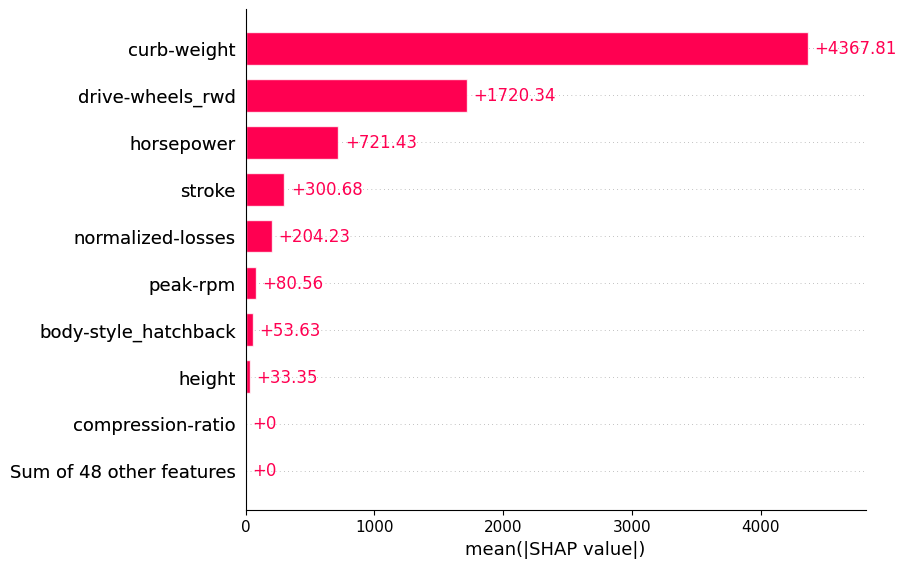

In [142]:
shap.plots.bar(explainer(X.iloc[:,:]))
# shap.plots.beeswarm(explainer(X.iloc[:,:]))

## Random Forest Regressor

In [ ]:
# Hyper parameters tuning for RandomForestRegressor
search_spaces_rfr = {
    'n_estimators': Integer(10, 200),
    'max_depth': Integer(1, 40),
    'min_samples_split': Integer(2, 15),
    'min_samples_leaf': Integer(1, 10)
}

bayes_optimizer(regressor=RandomForestRegressor(), search_spaces=search_spaces_rfr)

Best Parameters: OrderedDict([('max_depth', 40), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 103)])
R2 Score on Test Data: 0.8243203992787571

In [ ]:
# RandomForestRegressor instance
rfr = RandomForestRegressor(max_depth = 40, min_samples_leaf = 1,
                            min_samples_split = 2, n_estimators = 200
                            ).fit(X_train, y_train)

In [ ]:
# predict and show model metrics
y_pred_rfr, score_train_rfr, score_test_rfr = model_predict(model=rfr, test_X=X_test, test_y=y_test)

train score:  0.969
test score:  0.819
mae: 1417.3248877706203
mse: 4522859.266189705
rmse: 2126.7014990801376
R2: 0.8240299778454607

In [ ]:
# Predictions vs actual visuals
prediction_vs_actual_visuals(test_y=y_test, pred_y=y_pred_rfr)

In [ ]:
#Tree visualization
# Obtain only the first tree
first_tree = rfr.estimators_[0]

plt.figure(figsize=(30,20))
tree.plot_tree(first_tree,
               feature_names=X.columns,
               fontsize=8,
               filled=True,
               rounded=True);

In [ ]:
# Error analysis
actual_vs_pred_copm, above_treshold, bellow_trehsold = show_error_analysis(
    test_X=X_test, test_y=y_test, y_pred=y_pred_rfr, y_pred_label='y_pred_rfr'
  )

# Predictions vs actual results table
actual_vs_pred_copm.head(15)

In [ ]:
# prediction prices above threshold
above_treshold

In [ ]:
# prediction prices bellow threshold
bellow_trehsold

### Shap values

In [143]:
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(X)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

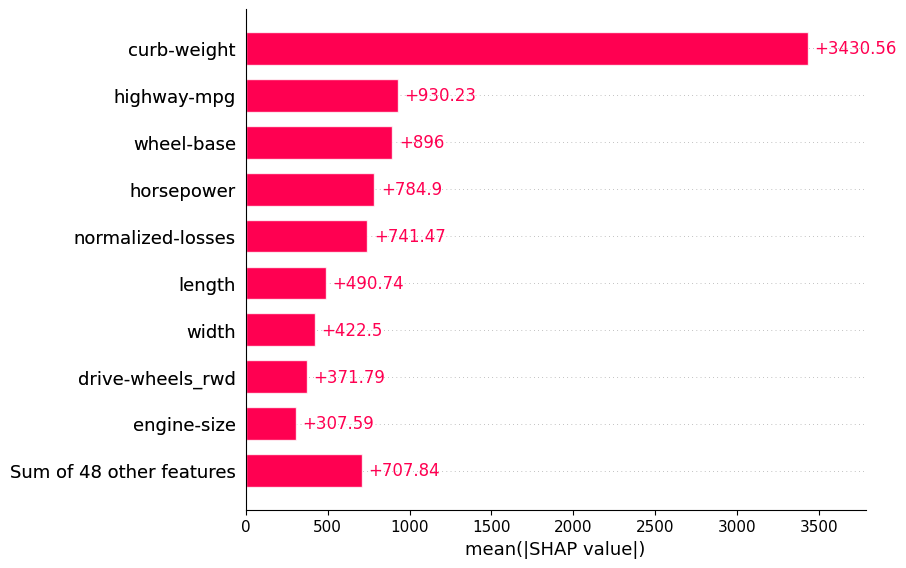

In [144]:
shap.plots.bar(explainer(X.iloc[:,:]))

## XGBoost Regressor

In [ ]:
# Hyper parameters tuning for RandomForestRegressor
search_spaces_xgb = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'min_child_weight': Integer(1, 10),
    'max_depth': Integer(1, 50),
    'max_delta_step': Integer(0, 20),
    'subsample': Real(0.01, 1.0, 'uniform'),
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),
    'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
    'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
    'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
    'gamma': Real(1e-9, 0.5, 'log-uniform'),
    'n_estimators': Integer(50, 500),
    'scale_pos_weight': Real(1e-6, 500, 'log-uniform')
}

bayes_optimizer(regressor=XGBRegressor(), search_spaces=search_spaces_xgb)

Best Parameters: OrderedDict([('colsample_bylevel', 0.06573080809029815), ('colsample_bytree', 1.0), ('gamma', 0.001576596163042287), ('learning_rate', 1.0), ('max_delta_step', 0), ('max_depth', 26), ('min_child_weight', 1), ('n_estimators', 500), ('reg_alpha', 7.553729923419456e-05), ('reg_lambda', 1000.0), ('scale_pos_weight', 0.07802144236376876), ('subsample', 1.0)])
R2 Score on Test Data: 0.8232570892373448

In [ ]:
# RandomForestRegressor instance
xgb = XGBRegressor(
    colsample_bylevel=0.06573080809029815,
    colsample_bytree=1.0,
    gamma=0.001576596163042287,
    learning_rate=1,
    max_delta_step=40,
    max_depth=26,
    min_child_weight=1,
    n_estimators=500,
    reg_alpha=7.553729923419456e-05,
    reg_lambda=1000.0,
    scale_pos_weight=0.07802144236376876,
    subsample=1.0
  ).fit(X_train, y_train)

In [ ]:
# predict and show model metrics
y_pred_xgb, score_train_xgb, score_test_xgb = model_predict(model=xgb, test_X=X_test, test_y=y_test)

train score:  0.972
test score:  0.829
mae: 1478.9239908854167
mse: 5758593.16679097
rmse: 2399.706891849705
R2: 0.775951514849394

In [ ]:
# Predictions vs actual visuals
prediction_vs_actual_visuals(test_y=y_test, pred_y=y_pred_xgb)

In [ ]:
# Error analysis
actual_vs_pred_copm, above_treshold, bellow_trehsold = show_error_analysis(
    test_X=X_test, test_y=y_test, y_pred=y_pred_xgb, y_pred_label='y_pred_xgb'
  )

# Predictions vs actual results table
actual_vs_pred_copm.head(15)

In [ ]:
# prediction prices above threshold
above_treshold

In [ ]:
# prediction prices bellow threshold
bellow_trehsold

### Shap values

In [145]:
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

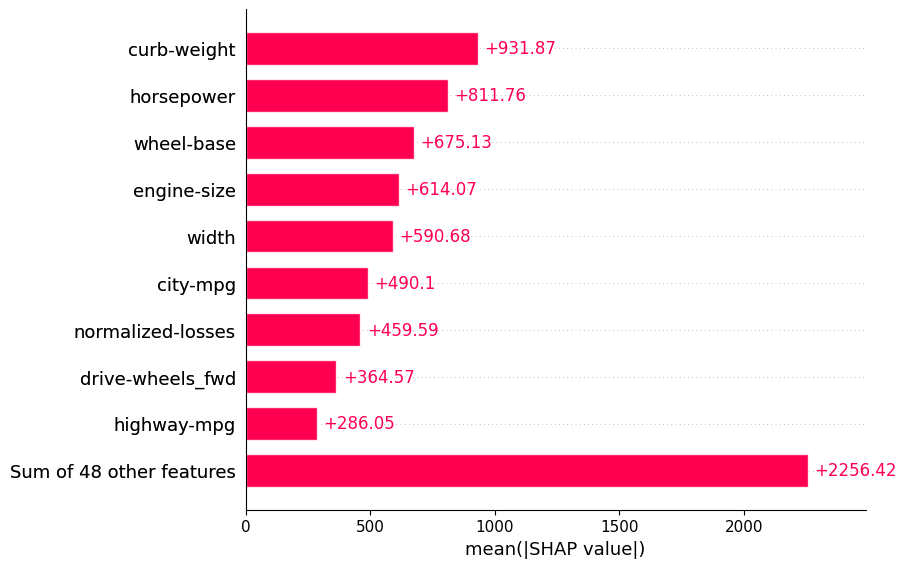

In [146]:
shap.plots.bar(explainer(X.iloc[:,:]))

## Score summary

In [ ]:
# Model score comparison betwen 'Decision Tree', 'Random Forest', and 'XGBoost'
train_scores = [score_train_dtr, score_train_rfr, score_train_xgb]
test_scores = [score_test_dtr, score_test_rfr, score_test_xgb]
models = ['Decision Tree', 'Random Forest', 'XGBoost']

dict_scores = {'train_score':train_scores, 'test_score':test_scores}

pd.DataFrame(dict_scores, index=models)

To summarize the results, it seems that all three models are overfitting. Therefore, it's necessary to reevaluate the features used. Some features are creating noise instead of providing useful signals, so they need to be excluded from the training process. Additionally, hyperparameters need to be retuned again. Due to a high number of unbalanced categorical columns, balancing techniques such as SMOTE need to be applied. It is also required to have a ***much larger dataset***.

Have purposely not excluded columns and further optimized the results so that subsequent analysis performed can be saved and viewed.

## Dump model

In [ ]:
# Save the model and model meta data  as a pickle files
model_filename = './auto_price_model_dtr.pkl'
joblib.dump(dtr, model_filename)

metadata_filename = './auto_price_model_metadata.pkl'
joblib.dump(X.columns.tolist(), metadata_filename)

# Predictions

In [147]:
def predict_price(data: pd.DataFrame, model_path: str, model_metadata_path: str) -> None:
  """
  Predict price based on pre-trained and serialized model and metadata

  :param data: pd.DataFrame: data for vehicles.
  :param model_path: str: path to the serialized model.
  :param model_metadata_path: str: path the the model metadata.

  :return: None: void.
  """
  # Load the model and metadata from the file
  regressor = joblib.load(model_path)
  regressor_metadata = joblib.load(model_metadata_path)

  # process data
  df = preprocess_dataframe(data=data)
  df = encoder(data=df, drop_first=False)

  # use the line bellow if new data has a price in it
  # df = df[get_features(data=df)]

  # add missing features/columns to align with one-hot encoding
  current_columns = df.columns.tolist()
  for c in regressor_metadata:
    if c not in current_columns:
      df[c] = 0

  # get results
  results = regressor.predict(df)

  print('Predictions:')
  for prediction in results:
      print(round(prediction,2))

In [148]:
new_data_cols = ['symboling', 'normalized-losses', 'make', 'fuel-type',
                 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels',
                 'engine-location', 'wheel-base', 'length', 'width', 'height',
                 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size',
                 'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower',
                 'peak-rpm', 'city-mpg', 'highway-mpg'
                 ]
new_data_values1 = [2,	164, 'audi', 'gas', 'std', 'four', 'sedan', 'fwd', 'front',
                   99.8, 176.6, 66.2,	54.3,	2337, 'ohc', 'four', 109, 'mpfi',
                   3.19, 3.4, 10.0, 102, 5500, 24, 30
                   ]

predict_price(data=pd.DataFrame([{k: v for k, v in zip(new_data_cols, new_data_values1)}]),
              model_path='./auto_price_model_dtr.pkl',
              model_metadata_path='./auto_price_model_metadata.pkl'
              )

Predictions:
13121.13
